In [1]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from scipy.interpolate import interp1d

#from moepy import lowess
from scipy.optimize import curve_fit # for power curve fitting
import sys
# appending a path with my modules
#sys.path.append(r'W:\PD-Engines\Engine Integration Validation\Department\Data Analytics\Wiktor\Python')
import Helpers

sns.set_theme()

color_dict = {'WTG007_old' : sns.color_palette()[0], #bluish
              'WTG007_new' : sns.color_palette()[3], # redish
              'WTG008' : sns.color_palette()[2],    #green
              'WTG007_predicted_w_old_LEP' : sns.color_palette()[4]}

## 0. Helper functions

In [2]:
%qtconsole

In [3]:
from utilities import (
    load_data_2024,
    clean_data,
    fit_logistic_power_curve,
    fit_lowess_power_curve,
    get_uniform_windspeed_distribution,
    logistic,
    initial_filter_over_1dcurve,
    fit_power_curve_poly6,
    fit_power_curve_IEC,
    calculate_filter_1dcurve,
    fit_linear_regression,
)

## 1. Loading data

In [4]:
df_2022, df_2023, df_2024, df, columns_translation = load_data_2024()

## 2. Cleaning and basic checks

In [6]:
df.columns

Index(['Timestamp', 'ActivePower', 'AmbTemp', 'NacelleDirection',
       'ProducedMWh', 'WindDirection', 'WindSpeed', 'WT'],
      dtype='object')

Text(0.5, 1.0, 'Data cleaning representation')

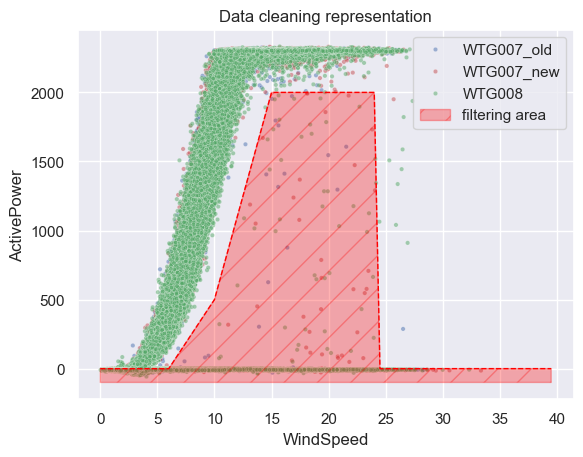

In [11]:
fig, ax = plt.subplots()
filtering_curve = calculate_filter_1dcurve()
sns.scatterplot(data=df.iloc[::10], s=10, x='WindSpeed', y='ActivePower', hue='WT', ax=ax, alpha=0.5, palette=color_dict)
sns.lineplot(x=np.arange(0, 40, 0.5), y=filtering_curve(np.arange(0, 40, 0.5)), label='_filtering curve', ax=ax, color='red', linestyle='--', linewidth =1)
ax.fill_between(np.arange(0, 40, 0.5), filtering_curve(np.arange(0, 40, 0.5)), y2= -100, color='red', alpha=0.3, hatch='/', label='filtering area')
plt.legend()
plt.title('Data cleaning representation')

In [20]:
df = clean_data(df)

Length before cleaning: 2105039
Length after cleaning: 1767954


In [10]:
df.WT.value_counts()

WT
WTG008        874328
WTG007_new    459352
WTG007_old    434274
Name: count, dtype: int64

In [11]:
df_wide_old = pd.merge(df[df.WT=='WTG007_old'], df[df.WT=='WTG008'], on ='Timestamp', suffixes=['_WTG007_old', '_WTG008'])
print(f"df_wide rows: {len(df_wide_old)}")
print(f"df[df.WT=='WTG007_old'] rows: {len(df[df.WT=='WTG007_old'])}")
print(f"df[df.WT=='WTG008'] rows: {len(df[df.WT=='WTG008'])}")
print(f"df_wide_old.date.min(): {df_wide_old.Timestamp.min()}")
print(f"df_wide_old.date.max(): {df_wide_old.Timestamp.max()}")

df_wide_old = df_wide_old.dropna(subset=['WindSpeed_WTG007_old', 'WindSpeed_WTG008', 'ActivePower_WTG007_old', 'ActivePower_WTG008'])
print(f"After dropping nans df_wide rows: {len(df_wide_old)}")

df_wide rows: 420479
df[df.WT=='WTG007_old'] rows: 434274
df[df.WT=='WTG008'] rows: 874328
df_wide_old.date.min(): 2022-10-10 00:00:00
df_wide_old.date.max(): 2023-09-30 23:59:00
After dropping nans df_wide rows: 420479


In [12]:
df_wide_new = pd.merge(df[df.WT=='WTG007_new'], df[df.WT=='WTG008'], on ='Timestamp', suffixes=['_WTG007_new', '_WTG008'])
print(f"df_wide_new rows: {len(df_wide_new)}")
print(f"df[df.WT=='WTG007_new'] rows: {len(df[df.WT=='WTG007_new'])}")
print(f"df[df.WT=='WTG008'] rows: {len(df[df.WT=='WTG008'])}")
print(f"df_wide_new.date.min(): {df_wide_new.Timestamp.min()}")
print(f"df_wide_new.date.max(): {df_wide_new.Timestamp.max()}")

df_wide_new = df_wide_new.dropna(subset=['WindSpeed_WTG007_new', 'WindSpeed_WTG008', 'ActivePower_WTG007_new', 'ActivePower_WTG007_new'])
print(f"After dropping nans df_wide rows: {len(df_wide_new)}")

df_wide_new rows: 428275
df[df.WT=='WTG007_new'] rows: 459352
df[df.WT=='WTG008'] rows: 874328
df_wide_new.date.min(): 2023-10-01 00:01:00
df_wide_new.date.max(): 2024-10-09 23:14:00
After dropping nans df_wide rows: 428275


In [60]:
df.head(5)

,Timestamp,ActivePower,AmbTemp,NacelleDirection,ProducedMWh,WindDirection,WindSpeed,WT
0,2022-10-10 00:00:00,2295.206897,NaN,205.526666,NaN,206.434783,12.239111,WTG007_old
1,2022-10-10 00:01:00,2303.254237,NaN,206.974998,NaN,208.105261,12.678475,WTG007_old
2,2022-10-10 00:02:00,2290.084746,NaN,207.050003,NaN,209.490745,12.844138,WTG007_old
3,2022-10-10 00:03:00,2304.116667,NaN,207.050003,NaN,208.132731,14.803898,WTG007_old
4,2022-10-10 00:04:00,2307.300000,NaN,207.050003,NaN,210.809616,14.382500,WTG007_old


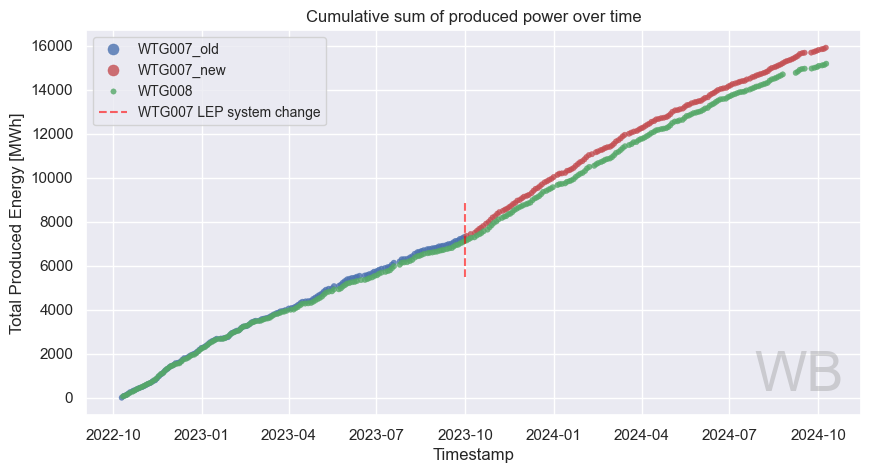

In [21]:
# Quick check if everything is loaded fine - we have less data now in 2023!
df['ProducedMWhCumsum'] = df.groupby('WT')['ProducedMWh'].cumsum()
WTG_7_old_energy_produced = df[df['WT'] == 'WTG007_old']['ProducedMWhCumsum'].dropna().iloc[-1]
# Shift WTG7_new to start from the place where WTG_7_old finished 
df.loc[df['WT'] == 'WTG007_new', 'ProducedMWhCumsum'] = df.loc[df['WT'] == 'WTG007_new', 'ProducedMWhCumsum'] + WTG_7_old_energy_produced

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(df.dropna(subset=['Timestamp', 'ProducedMWhCumsum']).iloc[::50],
                 x='Timestamp', y='ProducedMWhCumsum', hue='WT',
                 s=15, alpha=0.8, ax=ax, edgecolor=None, palette=color_dict)
ax.vlines(pd.Timestamp("2023-10-01"), 5500, 9000, color ='red', linestyles='dashed', alpha=0.6, label= 'WTG007 LEP system change' )
plt.title('Cumulative sum of produced power over time')
lgnd = plt.legend(loc="upper left", fontsize=10)
lgnd.legend_handles[0].set_markersize(8)
lgnd.legend_handles[1].set_markersize(8)
plt.ylabel('Total Produced Energy [MWh]')
# adjust point size for the legend

Helpers.add_watermark(ax)

## 2. Side by side analysis

### 2.1 Fit Power Curves

In [19]:
%qtconsole

In [48]:
power_curves = {}
df_fit = df[df.WindSpeed.between(2, 27)].copy()
for i, wt in enumerate(df['WT'].unique()):
    df_wt = df_fit[df_fit.WT == wt]
    power_curves[wt] = {}

    # Fit models
    [L, k, x0], R2_logistic = fit_logistic_power_curve(df_wt)  
    lowess_model, R2_lowess = fit_lowess_power_curve(df_wt)
    poly6_model, R2_poly6 = fit_power_curve_poly6(df_wt)
    IEC_model, R2_IEC = fit_power_curve_IEC(df_wt)

    power_curves[wt]['logistic'] = [[L, k, x0], R2_logistic]
    power_curves[wt]['lowess'] = [lowess_model, R2_lowess]
    power_curves[wt]['poly6'] = [poly6_model, R2_poly6] # poly6 is shit, we'll not continue with that one
    power_curves[wt]['IEC'] = [IEC_model, R2_IEC]
    
power_curves

C:\Users\wikto\AppData\Local\Temp\ipykernel_3584\2525054494.py:158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df.ActivePower.groupby(windSpeedBin).mean().reset_index()
C:\Users\wikto\AppData\Local\Temp\ipykernel_3584\2525054494.py:158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df.ActivePower.groupby(windSpeedBin).mean().reset_index()
C:\Users\wikto\AppData\Local\Temp\ipykernel_3584\2525054494.py:158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

{'WTG007_old': {'logistic': [[np.float64(2315.598788793695),
    np.float64(0.7990684279518501),
    np.float64(8.334456208101352)],
   0.9770529741112338],
  'lowess': [Lowess(), 0.9792259774986858],
  'poly6': [poly1d([-3.11903592e-03,  2.14607050e-01, -5.48643822e+00,  6.26715684e+01,
          -2.99642898e+02,  5.94438263e+02, -3.60127348e+02]),
   0.9464269102263763],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x26f03744ea0>,
   0.9740710153190313]},
 'WTG007_new': {'logistic': [[np.float64(2315.13047430683),
    np.float64(0.7980433519797944),
    np.float64(8.339932382948371)],
   0.9767709191252772],
  'lowess': [Lowess(), 0.9790984154208199],
  'poly6': [poly1d([-3.29096450e-03,  2.27561168e-01, -5.86869732e+00,  6.82348108e+01,
          -3.40834426e+02,  7.37668715e+02, -5.41416258e+02]),
   0.9302614279916178],
  'IEC': [<scipy.interpolate._interpolate.interp1d at 0x26f04e22d10>,
   0.9738161037631099]},
 'WTG008': {'logistic': [[np.float64(2314.1977093661108),
 

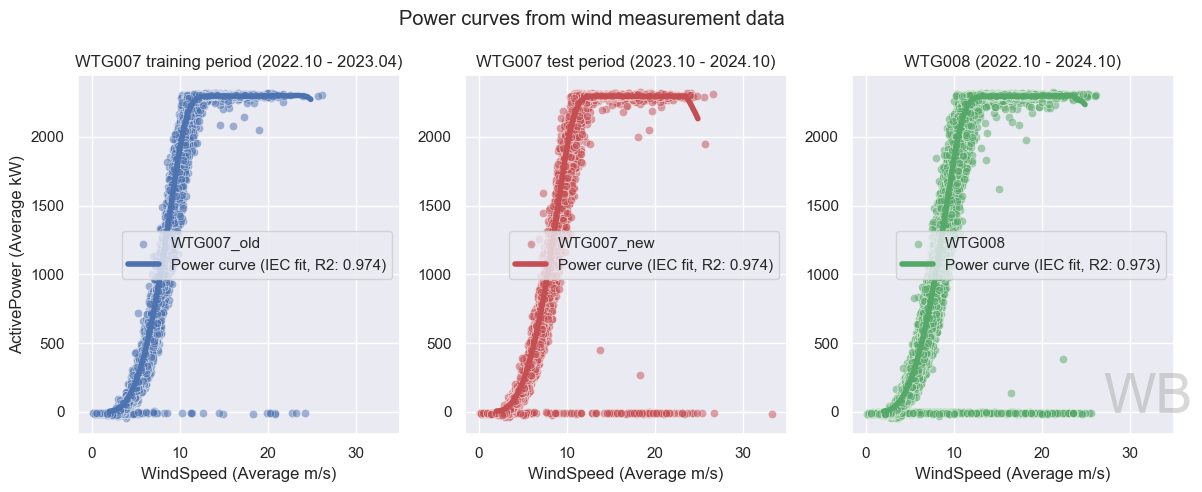

In [269]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 5))

for i, wt in enumerate(['WTG007_old', 'WTG007_new', 'WTG008']):
    ax = axes[i]
    df_wt = df[df.WT==wt].copy()
    sns.scatterplot(data=df_wt.iloc[::100], x='WindSpeed', y='ActivePower', alpha=0.5,
                    ax=ax, color=color_dict[wt], label=wt)
    ax.yaxis.set_tick_params(labelbottom=True) 
    ax.set_ylabel(columns_translation['ActivePower'])
    ax.set_xlabel(columns_translation['WindSpeed'])
    if wt == 'WTG007_old':
        title = 'WTG007 training period (2022.10 - 2023.04)'
    elif wt == 'WTG007_new':
        title = 'WTG007 test period (2023.10 - 2024.10)'
    elif wt == 'WTG008':
        title = 'WTG008 (2022.10 - 2024.10)'
    ax.set_title(title)

    # plot power curve
    wind_speed_grid = np.arange(0, 25, 0.1)
    model, R2 = power_curves[wt]['IEC']
    sns.lineplot(x=wind_speed_grid, y=model(wind_speed_grid), alpha=1,
                  color=color_dict[wt], ax = ax, linewidth=4, label=f'Power curve (IEC fit, R2: {R2:.3f})')
    
fig.suptitle('Power curves from wind measurement data')
plt.tight_layout()
Helpers.add_watermark(ax)

In [33]:
%qtconsole

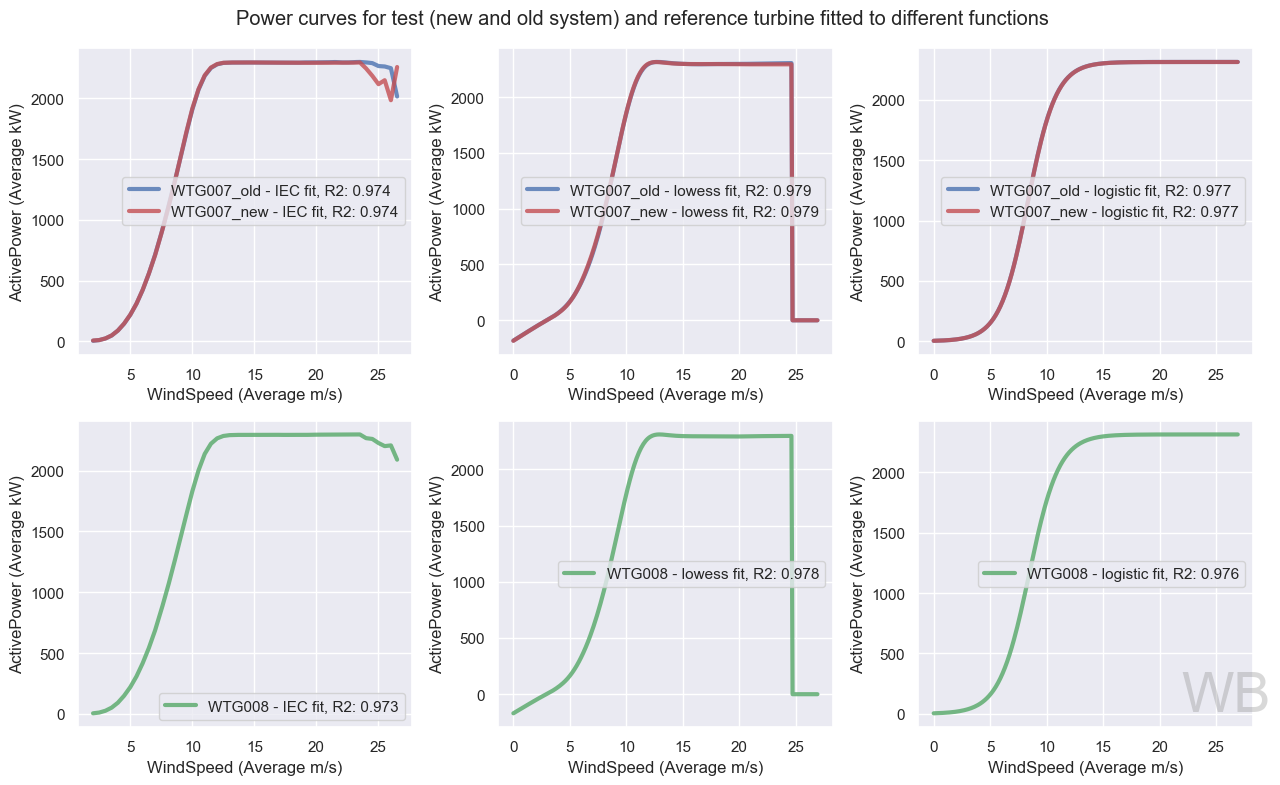

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))
wind_speed_grid = np.arange(0, 27, 0.1)

for col, model_name in enumerate(['IEC', 'lowess', 'logistic']):
    for row, wt in enumerate(['WTG007', 'WTG008']):
        ax = ax = axes[row, col]
        if wt == 'WTG007':
            for system in ['WTG007_old', 'WTG007_new']:
                model, R2 = power_curves[system][model_name]
                if model_name == 'lowess':
                    predictions = model.predict(wind_speed_grid)
                elif model_name == 'logistic':
                    predictions = logistic(wind_speed_grid, *model)
                else:
                    predictions = model(wind_speed_grid)
                # plot power curve
                sns.lineplot(x=wind_speed_grid, y=predictions,
                            color=color_dict[system], alpha=0.8, ax = ax, linewidth=3,
                            label=f'{system} - {model_name} fit, R2: {R2:.3f}')
        else:
        # plot power curve
            model, R2 = power_curves[wt][model_name]
            if model_name == 'lowess':
                    predictions = model.predict(wind_speed_grid)
            elif model_name == 'logistic':
                predictions = logistic(wind_speed_grid, *model)
            else:
                predictions = model(wind_speed_grid)
            sns.lineplot(x=wind_speed_grid, y=predictions,
                        color=color_dict[wt], alpha=0.8, ax = ax, linewidth=3,
                        label=f'{wt} - {model_name} fit, R2: {R2:.3f}')
        ax.set_ylabel(columns_translation['ActivePower'])
        ax.set_xlabel(columns_translation['WindSpeed'])

fig.suptitle('Power curves for test (new and old system) and reference turbine fitted to different functions')
Helpers.add_watermark(ax)
plt.tight_layout()

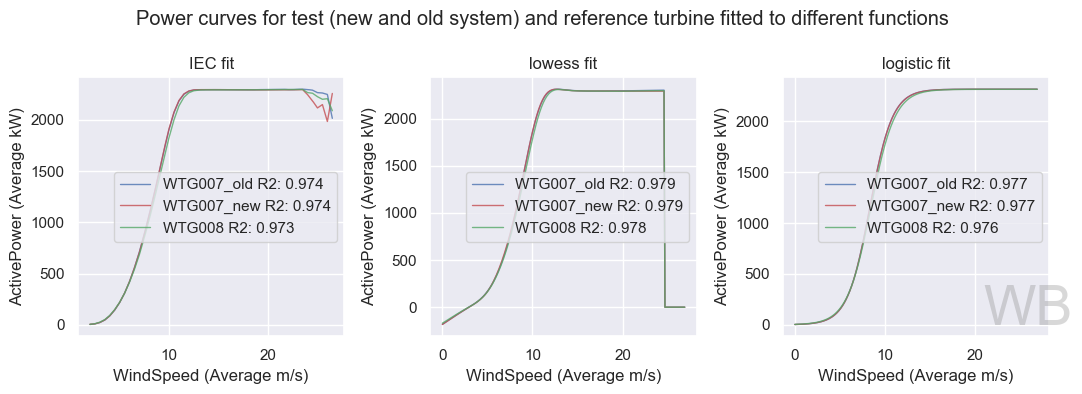

In [246]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))
wind_speed_grid = np.arange(0, 27, 0.1)

for col, model_name in enumerate(['IEC', 'lowess', 'logistic']):
    for row, wt in enumerate(['WTG007_old', 'WTG007_new', 'WTG008']):
        ax = axes[col]
        
        model, R2 = power_curves[wt][model_name]
        if model_name == 'lowess':
                predictions = model.predict(wind_speed_grid)
        elif model_name == 'logistic':
            predictions = logistic(wind_speed_grid, *model)
        else:
            predictions = model(wind_speed_grid)
        sns.lineplot(x=wind_speed_grid, y=predictions,
                    color=color_dict[wt], alpha=0.8, ax = ax, linewidth=1,
                    label=f'{wt} R2: {R2:.3f}')
        ax.set_title(f'{model_name} fit')
        ax.set_ylabel(columns_translation['ActivePower'])
        ax.set_xlabel(columns_translation['WindSpeed'])

fig.suptitle('Power curves for test (new and old system) and reference turbine fitted to different functions')
Helpers.add_watermark(ax)
plt.tight_layout()

In [92]:
%qtconsole

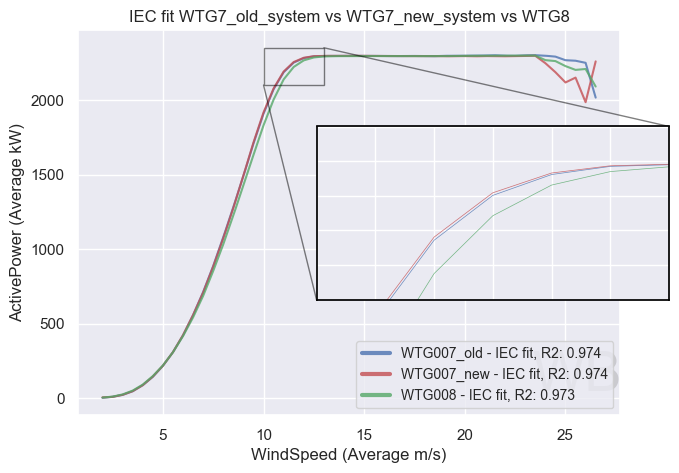

In [267]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

model_name = 'IEC'
for wt in ['WTG007_old', 'WTG007_new', 'WTG008']:
    ax = axes
    model, R2 = power_curves[wt][model_name]
    if model_name == 'lowess':
            predictions = model.predict(wind_speed_grid)
    elif model_name == 'logistic':
        predictions = logistic(wind_speed_grid, *model)
    else:
        predictions = model(wind_speed_grid)
    sns.lineplot(x=wind_speed_grid, y=predictions,
                color=color_dict[wt], alpha=0.8, ax = ax, linewidth=1.5,
                label=f'{wt} - {model_name} fit, R2: {R2:.3f}')
    ax.set_ylabel(columns_translation['ActivePower'])
    ax.set_xlabel(columns_translation['WindSpeed'])

#plot again for zoomed axes
with plt.rc_context({'axes.edgecolor':'black'}):
    ax_zoomed = ax.inset_axes([0.44, 0.3, 0.65, 0.45])
x1, x2, y1, y2 = 10, 13, 2100, 2350
ax_zoomed.set_xlim(x1, x2)
ax_zoomed.set_ylim(y1, y2)
ax_zoomed.set_xticklabels([])
ax_zoomed.set_yticklabels([])
ax.indicate_inset_zoom(ax_zoomed, edgecolor="black")
lgnd = ax.legend(loc="lower right", fontsize=10)
for handles in lgnd.legend_handles:
    handles.set_linewidth(3)
for wt in ['WTG007_old', 'WTG007_new', 'WTG008']:
    ax_zoomed
    model, R2 = power_curves[wt][model_name]
    if model_name == 'lowess':
        predictions = model.predict(wind_speed_grid)
    elif model_name == 'logistic':
        predictions = logistic(wind_speed_grid, *model)
    else:
        predictions = model(wind_speed_grid)
    sns.lineplot(x=wind_speed_grid, y=predictions,
                color=color_dict[wt], alpha=0.8, ax = ax_zoomed, linewidth=0.5)
ax.set_title('IEC fit WTG7_old_system vs WTG7_new_system vs WTG8')
Helpers.add_watermark(ax)

Text(0.5, 1.0, 'lowess fit WTG7_old_system vs WTG7_new_system vs WTG8')

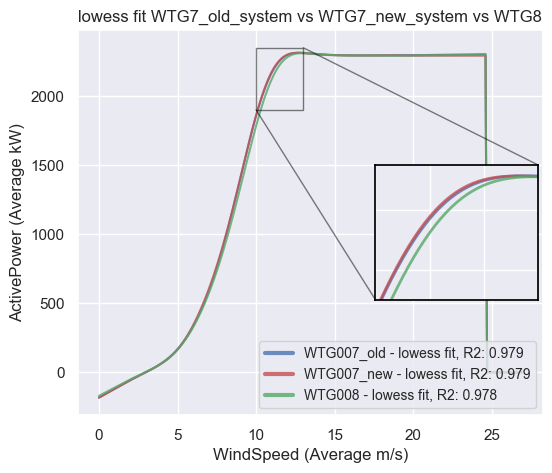

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

model_name = 'lowess'
for wt in ['WTG007_old', 'WTG007_new', 'WTG008']:
    ax = axes
    model, R2 = power_curves[wt][model_name]
    if model_name == 'lowess':
            predictions = model.predict(wind_speed_grid)
    elif model_name == 'logistic':
        predictions = logistic(wind_speed_grid, *model)
    else:
        predictions = model(wind_speed_grid)
    sns.lineplot(x=wind_speed_grid, y=predictions,
                color=color_dict[wt], alpha=0.8, ax = ax, linewidth=1.5,
                label=f'{wt} - {model_name} fit, R2: {R2:.3f}')
    ax.set_ylabel(columns_translation['ActivePower'])
    ax.set_xlabel(columns_translation['WindSpeed'])

#plot again for zoomed axes
with plt.rc_context({'axes.edgecolor':'black'}):
    ax_zoomed = ax.inset_axes([0.64, 0.3, 0.35, 0.35])
x1, x2, y1, y2 = 10, 13, 1900, 2350
ax_zoomed.set_xlim(x1, x2)
ax_zoomed.set_ylim(y1, y2)
ax_zoomed.set_xticklabels([])
ax_zoomed.set_yticklabels([])
ax.indicate_inset_zoom(ax_zoomed, edgecolor="black")
lgnd = ax.legend(loc="lower right", fontsize=10)
for handles in lgnd.legend_handles:
    handles.set_linewidth(3)
for wt in ['WTG007_old', 'WTG007_new', 'WTG008']:
    ax_zoomed
    model, R2 = power_curves[wt][model_name]
    if model_name == 'lowess':
        predictions = model.predict(wind_speed_grid)
    elif model_name == 'logistic':
        predictions = logistic(wind_speed_grid, *model)
    else:
        predictions = model(wind_speed_grid)
    sns.lineplot(x=wind_speed_grid, y=predictions,
                color=color_dict[wt], alpha=0.8, ax = ax_zoomed, linewidth=2)
ax.set_title(f'{model_name} fit WTG7_old_system vs WTG7_new_system vs WTG8')

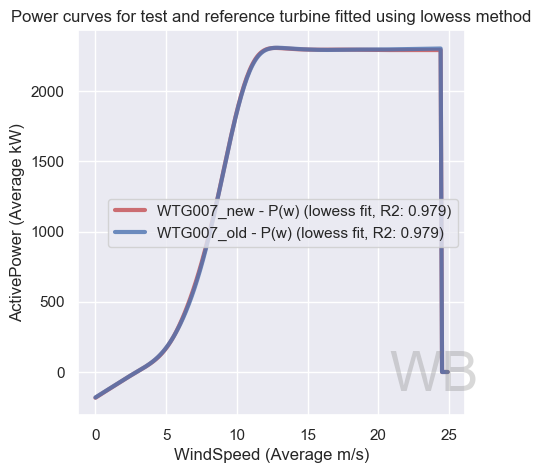

In [123]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

for i, wt in enumerate(['WTG007_new', 'WTG007_old']):
    ax.set_ylabel(columns_translation['ActivePower'])
    ax.set_xlabel(columns_translation['WindSpeed'])

    # plot power curve
    wind_speed_grid = np.arange(0, 25, 0.1)
    lowess_model, R2 = power_curves[wt]['lowess']
    sns.lineplot(x=wind_speed_grid, y=lowess_model.predict(wind_speed_grid),
                color=color_dict[wt], alpha=0.8, ax = ax, linewidth=3,
                label=f'{wt} - P(w) (lowess fit, R2: {R2:.3f})')
ax.set_title('Power curves for test and reference turbine fitted using lowess method')
Helpers.add_watermark(ax)

### 2.2 Correlate Power output old with Power output reference

In [124]:
df_wide_old.columns

Index(['Timestamp', 'ActivePower_WTG007_old', 'AmbTemp_WTG007_old',
       'NacelleDirection_WTG007_old', 'ProducedMWh_WTG007_old',
       'WindDirection_WTG007_old', 'WindSpeed_WTG007_old', 'WT_WTG007_old',
       'ActivePower_WTG008', 'AmbTemp_WTG008', 'NacelleDirection_WTG008',
       'ProducedMWh_WTG008', 'WindDirection_WTG008', 'WindSpeed_WTG008',
       'WT_WTG008'],
      dtype='object')

In [210]:
df_wide_10min_avg_old = df_wide_old[[col for col in df_wide_old.columns if col not in ['WT_WTG008', 'WT_WTG007_old']]].set_index('Timestamp').rolling(10).mean().iloc[::10]
df_wide_10min_avg_old = df_wide_10min_avg_old.reset_index()

df_wide_10min_avg_new = df_wide_new[[col for col in df_wide_new.columns if col not in ['WT_WTG008', 'WT_WTG007_new']]].set_index('Timestamp').rolling(10).mean().iloc[::10]
df_wide_10min_avg_new = df_wide_10min_avg_new.reset_index()

# fit linear regression for P relation
# get rid of nans

P_rel_WTG7old_WTG8, R2_old = fit_linear_regression(df_wide_10min_avg_old, y_col='ActivePower_WTG007_old')
print(P_rel_WTG7old_WTG8.coef_)
P_rel_WTG7new_WTG8, R2_new = fit_linear_regression(df_wide_10min_avg_new, y_col='ActivePower_WTG007_new')
print(P_rel_WTG7new_WTG8.coef_)

[0.98122715]
[0.9889686]


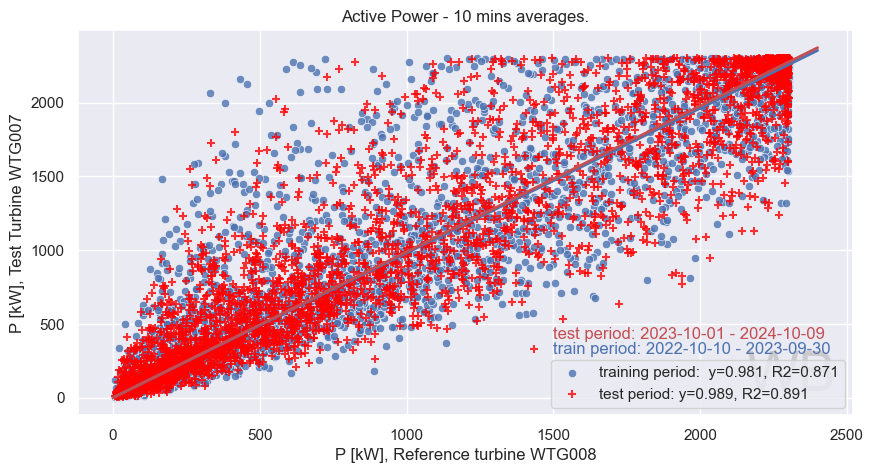

In [240]:
fig, ax = plt.subplots(figsize=(10, 5))

test_period = f'{df_wide_10min_avg_new.Timestamp.min().strftime("%Y-%m-%d")} - {df_wide_10min_avg_new.Timestamp.max().strftime("%Y-%m-%d")}'
train_period = f'{df_wide_10min_avg_old.Timestamp.min().strftime("%Y-%m-%d")} - {df_wide_10min_avg_old.Timestamp.max().strftime("%Y-%m-%d")}'

x_gird_P = np.arange(0, 2500, 100).reshape(-1, 1)
sns.scatterplot(data = df_wide_10min_avg_old.iloc[::10], y='ActivePower_WTG007_old', x='ActivePower_WTG008',
                alpha=0.8, 
                label=f'training period:  y={P_rel_WTG7old_WTG8.coef_[0]:.3f}, R2={R2_old:.3f}', ax = ax)
sns.scatterplot(data = df_wide_10min_avg_new.iloc[::10], y='ActivePower_WTG007_new', x='ActivePower_WTG008',
                color= 'red', alpha=0.8, marker='+', linewidth=1.5,
                label=f'test period: y={P_rel_WTG7new_WTG8.coef_[0]:.3f}, R2={R2_new:.3f}', ax = ax)

plt.plot(x_gird_P, P_rel_WTG7old_WTG8.predict(x_gird_P), color=color_dict['WTG007_old'], linewidth=2)
plt.plot(x_gird_P, P_rel_WTG7new_WTG8.predict(x_gird_P), color=color_dict['WTG007_new'], linewidth=2)

plt.xlabel('P [kW], Reference turbine WTG008')
plt.ylabel('P [kW], Test Turbine WTG007')
plt.title(f"Active Power - 10 mins averages.")
plt.text(1500, 300, s=f'train period: {train_period}', color=color_dict['WTG007_old'])
plt.text(1500, 400, s=f'test period: {test_period}', color=color_dict['WTG007_new'])
Helpers.add_watermark(plt.gca())

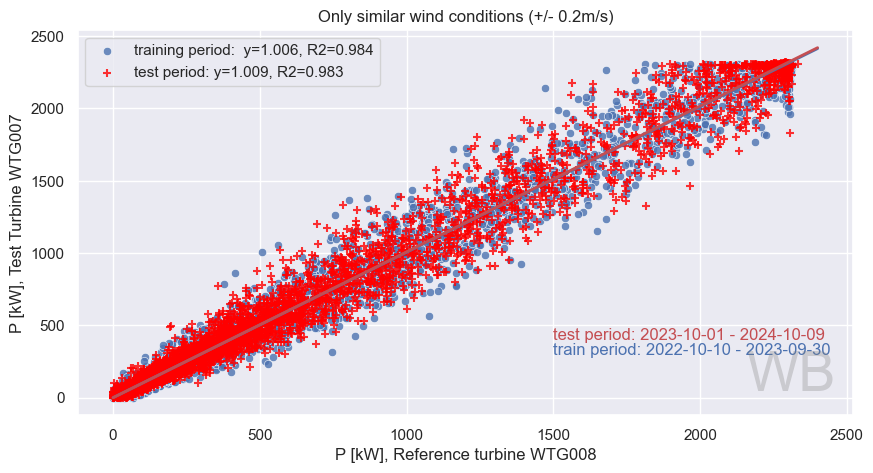

In [244]:
similar_winds_old = df_wide_old[(abs(df_wide_old['WindSpeed_WTG007_old'] - df_wide_old['WindSpeed_WTG008']) <0.2)]
similar_winds_new = df_wide_new[(abs(df_wide_new['WindSpeed_WTG007_new'] - df_wide_new['WindSpeed_WTG008']) <0.2)]

P_rel_WTG7old_WTG8_sw, R2_old_sw = fit_linear_regression(similar_winds_old, y_col='ActivePower_WTG007_old')
P_rel_WTG7new_WTG8_sw, R2_new_sw = fit_linear_regression(similar_winds_new, y_col='ActivePower_WTG007_new')

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = similar_winds_old.iloc[::10], y='ActivePower_WTG007_old', x='ActivePower_WTG008',
                alpha=0.8, 
                label=f'training period:  y={P_rel_WTG7old_WTG8_sw.coef_[0]:.3f}, R2={R2_old_sw:.3f}', ax = ax)
sns.scatterplot(data = similar_winds_new.iloc[::10], y='ActivePower_WTG007_new', x='ActivePower_WTG008',
                color= 'red', alpha=0.8, marker='+', linewidth=1.5,
                label=f'test period: y={P_rel_WTG7new_WTG8_sw.coef_[0]:.3f}, R2={R2_new_sw:.3f}', ax = ax)


plt.plot(x_gird_P, P_rel_WTG7old_WTG8_sw.predict(x_gird_P), color=color_dict['WTG007_old'], linewidth=2)
plt.plot(x_gird_P, P_rel_WTG7new_WTG8_sw.predict(x_gird_P), color=color_dict['WTG007_new'], linewidth=2)

plt.text(1500, 300, s=f'train period: {train_period}', color=color_dict['WTG007_old'])
plt.text(1500, 400, s=f'test period: {test_period}', color=color_dict['WTG007_new'])
ax.set_title('Only similar wind conditions (+/- 0.2m/s)')

plt.xlabel('P [kW], Reference turbine WTG008')
plt.ylabel('P [kW], Test Turbine WTG007')
Helpers.add_watermark(ax)

### 3. Power curve of ref as a function of wind speed at test

## Additional request 08.02.2025

Prośba z naszej strony. Czy możesz wyciągnąć z Twojego zestawienia danych, ile Turbina 7 oraz turbina 8 wyprodukowały MWh w przedziale czasowym 10.2022 – 10.2023 oraz ile w przedziale czasowym 10.2023 – 10.2024.

Dodatkowo o ile w % rozwiązanie Navigi zwiększyło AEP turbiny 7 w stosunku do sytuacji, gdzie rozwiązanie nie byłoby zainstalowane.

In this analysis part we don't clean data, as we'll work only on produced power part

In [115]:
%qtconsole

In [4]:
_, _, _, df, columns_translation = load_data()
df['ProducedMWhCumsum'] = df.groupby('WT')['ProducedMWh'].cumsum()
WTG_7_old_energy_produced = df[df['WT'] == 'WTG007_old']['ProducedMWhCumsum'].dropna().iloc[-1]
df.loc[df['WT'] == 'WTG007_new', 'ProducedMWhCumsum'] = df.loc[df['WT'] == 'WTG007_new', 'ProducedMWhCumsum'] + WTG_7_old_energy_produced

In [30]:
df.columns

Index(['Timestamp', 'ActivePower', 'AmbTemp', 'NacelleDirection',
       'ProducedMWh', 'WindDirection', 'WindSpeed', 'WT'],
      dtype='object')

### A.1 Fit generated power on WT007_old to WT008 generated power

In [23]:
df_WTG7_old = df[df['WT'] == 'WTG007_old'].set_index('Timestamp')[['ProducedMWh', 'WT', 'ProducedMWhCumsum']].dropna()
df_WTG8 = df[df['WT'] == 'WTG008'].set_index('Timestamp')[['ProducedMWh', 'WT', 'ProducedMWhCumsum']].dropna()

df_WTG7_old_WTG8 = pd.merge(left=df_WTG7_old, right=df_WTG8, on='Timestamp', suffixes =['_WTG7_old', '_WTG8'])
df_WTG7_old_WTG8.columns

Index(['ProducedMWh_WTG7_old', 'WT_WTG7_old', 'ProducedMWhCumsum_WTG7_old',
       'ProducedMWh_WTG8', 'WT_WTG8', 'ProducedMWhCumsum_WTG8'],
      dtype='object')

In [24]:
x = df_WTG7_old_WTG8['ProducedMWhCumsum_WTG8'].values.reshape(-1, 1)
y = df_WTG7_old_WTG8['ProducedMWhCumsum_WTG7_old'].values

lr_ProducedMWh = LinearRegression(fit_intercept = False).fit(x , y)
print(f'Intercept: {lr_ProducedMWh.intercept_}')
print(f'Coefficient: {lr_ProducedMWh.coef_}')

Intercept: 0.0
Coefficient: [1.02360693]


Text(0.5, 1.0, ' Energy production (EP) on WTG7 with old LEP as a function of EP on WTG8. 10.2022 - 10.2023')

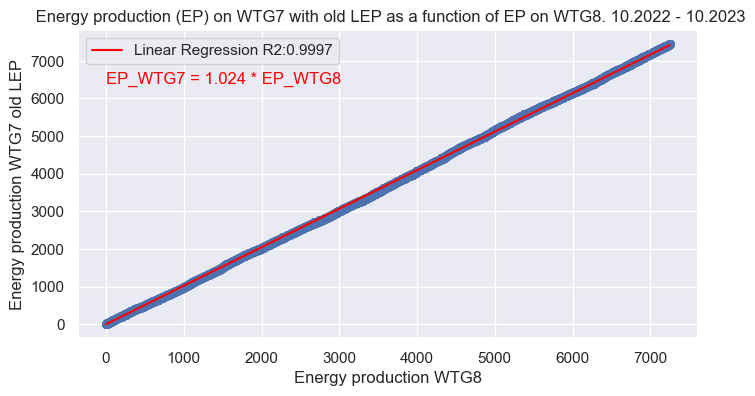

In [6]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_WTG7_old_WTG8,
                x='ProducedMWhCumsum_WTG8', 
                y='ProducedMWhCumsum_WTG7_old', 
                alpha=0.8,
                edgecolor=color_dict['WTG007_old'])
sns.lineplot(x=x.reshape(-1), y=lr_ProducedMWh.predict(x), color='red', label =f'Linear Regression R2:{r2_score(y, lr_ProducedMWh.predict(x)):.4}')
plt.text(x=0, y= 6400, s=f'EP_WTG7 = {lr_ProducedMWh.coef_[0]:.3f} * EP_WTG8', color='red')
plt.ylabel('Energy production WTG7 old LEP')
plt.xlabel('Energy production WTG8')
plt.title(" Energy production (EP) on WTG7 with old LEP as a function of EP on WTG8. 10.2022 - 10.2023")

In [7]:
df_WTG7_old.index[0]

Timestamp('2022-10-10 00:59:00')

In [25]:
period_I_start = df_WTG7_old.index[0]
period_I_end = df_WTG7_old.index[-1]

period_II_start = pd.Timestamp('2023-10-10 00:59:00')
period_II_end = pd.Timestamp('2024-09-30 23:59:00')
print(f"Period I: {period_I_start} - {period_I_end}")
print(f"Period II: {period_II_start} - {period_II_end}")

Period I: 2022-10-10 00:59:00 - 2023-09-30 23:59:00
Period II: 2023-10-10 00:59:00 - 2024-09-30 23:59:00


In [26]:
df_predicted_WTG7_old = df[(df.WT=='WTG008') & (df['Timestamp'] > period_I_end)].copy()
df_predicted_WTG7_old['WT'] = 'WTG007_predicted_w_old_LEP'
id_non_nan = df_predicted_WTG7_old['ProducedMWhCumsum'].dropna().index
df_predicted_WTG7_old.loc[id_non_nan, 'ProducedMWhCumsum'] = lr_ProducedMWh.predict(
    df_predicted_WTG7_old.loc[id_non_nan, 'ProducedMWhCumsum'].values.reshape(-1, 1))
df = pd.concat([df, df_predicted_WTG7_old])

In [27]:
df.loc[df.WT=='WTG007_predicted_w_old_LEP', 'ProducedMWh'] = np.nan # only cumsum is predicted

In [29]:
%matplotlib widget

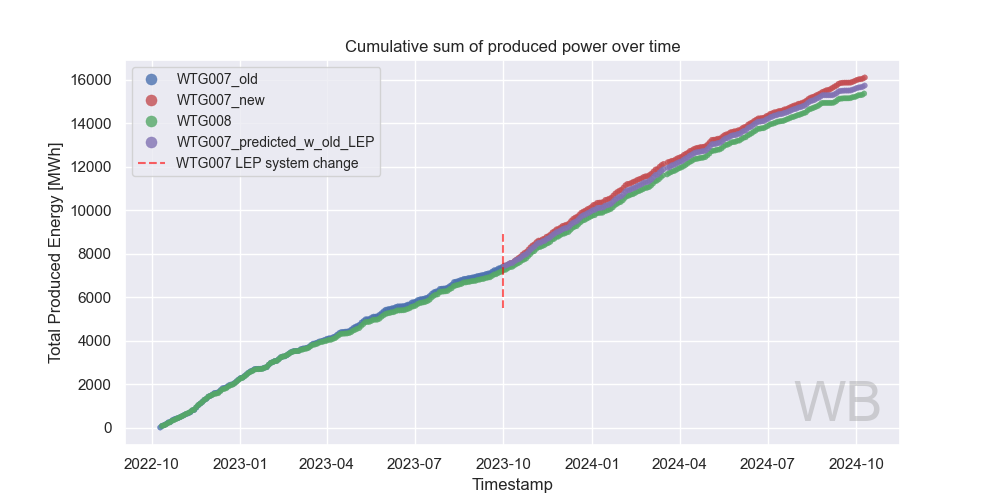

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(df.dropna(subset=['Timestamp', 'ProducedMWhCumsum']).iloc[::50],
                 x='Timestamp', y='ProducedMWhCumsum', hue='WT',
                 s=15, alpha=0.8, ax=ax, edgecolor=None, palette=color_dict)
ax.vlines(pd.Timestamp("2023-10-01"), 5500, 9000, color ='red', linestyles='dashed', alpha=0.6, label= 'WTG007 LEP system change' )
plt.title('Cumulative sum of produced power over time')
lgnd = plt.legend(loc="upper left", fontsize=10)
lgnd.legend_handles[0].set_markersize(8)
lgnd.legend_handles[1].set_markersize(8)
lgnd.legend_handles[2].set_markersize(8)
lgnd.legend_handles[3].set_markersize(8)
plt.ylabel('Total Produced Energy [MWh]')
# adjust point size for the legend

Helpers.add_watermark(ax)

In [12]:
df.groupby('WT').aggregate({'ProducedMWh' :'sum',
                            'Timestamp' : ['min', 'max']})

ProducedMWh           Timestamp  \
                                     sum                 min   
WT                                                             
WTG007_new                   8657.227474 2023-10-01 00:01:00   
WTG007_old                   7443.907473 2022-10-10 00:00:00   
WTG007_predicted_w_old_LEP      0.000000 2023-10-01 00:00:00   
WTG008                      15367.874767 2022-10-10 00:00:00   

                                                
                                           max  
WT                                              
WTG007_new                 2024-10-09 23:59:00  
WTG007_old                 2023-09-30 23:59:00  
WTG007_predicted_w_old_LEP 2024-10-09 23:59:00  
WTG008                     2024-10-09 23:59:00

In [14]:
print("Period 1")
(df[(df['Timestamp'] >= period_I_start) & (df['Timestamp'] < period_I_end)]
    .groupby('WT').aggregate({'ProducedMWh' :'sum',
                            'Timestamp' : ['min', 'max']})
)

Period 1


ProducedMWh           Timestamp                    
                    sum                 min                 max
WT                                                             
WTG007_old  7443.494448 2022-10-10 00:59:00 2023-09-30 23:58:00
WTG008      7249.840832 2022-10-10 00:59:00 2023-09-30 23:58:00

In [15]:
print("Period 2")
(df[(df['Timestamp'] >= period_II_start) & (df['Timestamp'] < period_II_end)]
    .groupby('WT').aggregate({'ProducedMWh' :'sum',
                            'Timestamp' : ['min', 'max']})
)

Period 2


ProducedMWh           Timestamp  \
                                    sum                 min   
WT                                                            
WTG007_new                  8406.141351 2023-10-10 00:59:00   
WTG007_predicted_w_old_LEP     0.000000 2023-10-10 00:59:00   
WTG008                      7848.222221 2023-10-10 00:59:00   

                                                
                                           max  
WT                                              
WTG007_new                 2024-09-30 23:58:00  
WTG007_predicted_w_old_LEP 2024-09-30 23:58:00  
WTG008                     2024-09-30 23:58:00

In [17]:
print()
print((df[(df['WT']=='WTG007_predicted_w_old_LEP') \
    & (df['Timestamp'] > period_II_start) & (df['Timestamp'] < period_II_end)]
   .groupby('WT')
   .aggregate({'ProducedMWhCumsum' : ['last', 'first'], 'Timestamp' : ['min', 'max']})))



                           ProducedMWhCumsum                        Timestamp  \
                                        last        first                 min   
WT                                                                              
WTG007_predicted_w_old_LEP      15601.143121  7567.686741 2023-10-10 01:00:00   

                                                
                                           max  
WT                                              
WTG007_predicted_w_old_LEP 2024-09-30 23:58:00  


### Correction for the time when WTG8 in period II was not working !

In [35]:
test = df[
    (df["WT"] == 'WTG008')
    & (df['Timestamp'] > pd.Timestamp("2023-08-15"))]
test

,Timestamp,ActivePower,AmbTemp,NacelleDirection,ProducedMWh,WindDirection,WindSpeed,WT,ProducedMWhCumsum
1497421,2023-08-15 00:01:00,414.117647,13.500000,NaN,NaN,147.051020,5.942000,WTG008,NaN
1497422,2023-08-15 00:02:00,403.444444,13.500000,NaN,NaN,144.650943,5.872800,WTG008,NaN
1497423,2023-08-15 00:03:00,354.961538,13.500000,143.825001,NaN,141.321154,5.465185,WTG008,NaN
1497424,2023-08-15 00:04:00,416.622642,13.454545,143.233332,NaN,147.582456,6.013929,WTG008,NaN
1497425,2023-08-15 00:05:00,393.222222,13.529412,144.366664,NaN,141.100000,6.135862,WTG008,NaN
...,...,...,...,...,...,...,...,...,...
2105035,2024-10-09 23:55:00,-15.250000,NaN,NaN,NaN,287.383346,2.072632,WTG008,NaN
2105036,2024-10-09 23:56:00,-13.347826,NaN,NaN,NaN,286.768977,1.907925,WTG008,NaN
2105037,2024-10-09 23:57:00,-13.500000,NaN,NaN,NaN,284.664298,1.836964,WTG008,NaN
2105038,2024-10-09 23:58:00,-14.333333,NaN,NaN,NaN,280.216679,1.676154,WTG008,NaN


In [63]:
day_production_WTG8 = test.groupby(test['Timestamp'].dt.date)['ProducedMWh'].sum()
day_production_WTG7_new = df[
    (df["WT"] == 'WTG007_new')
    & (df['Timestamp'] > pd.Timestamp("2023-08-15"))]
day_production_WTG7_new = day_production_WTG7_new.groupby(day_production_WTG7_new['Timestamp'].dt.date)['ProducedMWh'].sum()
day_production = pd.merge(day_production_WTG8, day_production_WTG7_new, on ='Timestamp', suffixes=['_WTG8', '_WTG7_new'])
day_production = day_production.reset_index()


Issue is for days 2024-08-27 to incl. 2024-09-06, total of 11 days. On last day production already statrted and was 3.9MWh, this will be corrected

In [73]:
day_production[day_production['Timestamp'].between(pd.Timestamp("2024-08-27").date(), pd.Timestamp("2024-09-06").date())]

,Timestamp,ProducedMWh_WTG8,ProducedMWh_WTG7_new
331,2024-08-27,-0.054862,16.560977
332,2024-08-28,-0.035674,16.327681
333,2024-08-29,-0.024032,21.193837
334,2024-08-30,-0.037231,22.202704
335,2024-08-31,-0.026678,5.446189
336,2024-09-01,-0.025673,4.165187
337,2024-09-02,-0.044971,16.036951
338,2024-09-03,-0.104685,27.602542
339,2024-09-04,-0.155083,8.815942
340,2024-09-05,-0.190030,41.060045


In [72]:
day_production[day_production['Timestamp'].between(pd.Timestamp("2024-08-27").date(), pd.Timestamp("2024-09-06").date())][['ProducedMWh_WTG8','ProducedMWh_WTG7_new']].sum()

ProducedMWh_WTG8          3.286038
ProducedMWh_WTG7_new    206.236103
dtype: float64